In [1]:
import warnings
import umap
import torch

import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn import decomposition, preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from collections import Counter
from scipy import stats
from scipy.spatial import distance

from IPython.display import display, Markdown

from torch.nn import functional as F

from news_vec.encoder import read_preds

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [3]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 200

In [5]:
df, embeds = read_preds('../data/ava-lstm-attn/')

100%|██████████| 284/284 [00:15<00:00, 24.45it/s]


In [6]:
DOMAINS = df.domain.unique()

In [7]:
DOMAINS

array(['cnn.com', 'dailycaller.com', 'breitbart.com', 'dailykos.com',
       'npr.org', 'msnbc.com', 'bloomberg.com', 'nytimes.com',
       'washingtonpost.com', 'wsj.com', 'buzzfeed.com', 'apnews.com',
       'huffingtonpost.com', 'thehill.com', 'foxnews.com'], dtype=object)

In [8]:
embeds.shape

(283650, 512)

In [9]:
dr = decomposition.TruncatedSVD(10)
embedding = dr.fit_transform(embeds[df.index])

In [10]:
dr.explained_variance_ratio_

array([0.18248266, 0.15567052, 0.068037  , 0.09151658, 0.06696202,
       0.06867218, 0.05140177, 0.03429626, 0.0281141 , 0.02733259],
      dtype=float32)

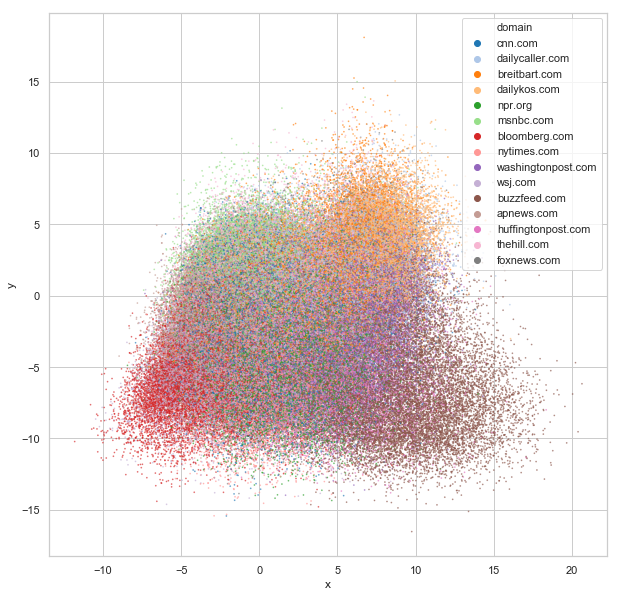

In [11]:
points = df.copy()
points['x'] = embedding[:,0]
points['y'] = embedding[:,1]

plt.figure(figsize=(10,10))

sns.scatterplot(
    x='x',
    y='y',
    data=points,
    s=1,
    edgecolor=None,
    alpha=0.5,
    hue='domain',
    palette='tab20',
)

In [12]:
pdf = df[df.domain.isin(['nytimes.com', 'breitbart.com', 'npr.org'])]
pdf['tokens_key'] = pdf.clf_tokens.apply(lambda ts: tuple(ts))
pdf = pdf.drop_duplicates('tokens_key')

dr = umap.UMAP(metric='cosine', verbose=True)
UMAP_EMBEDDING = dr.fit_transform(embeds[pdf.index])

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='cosine',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


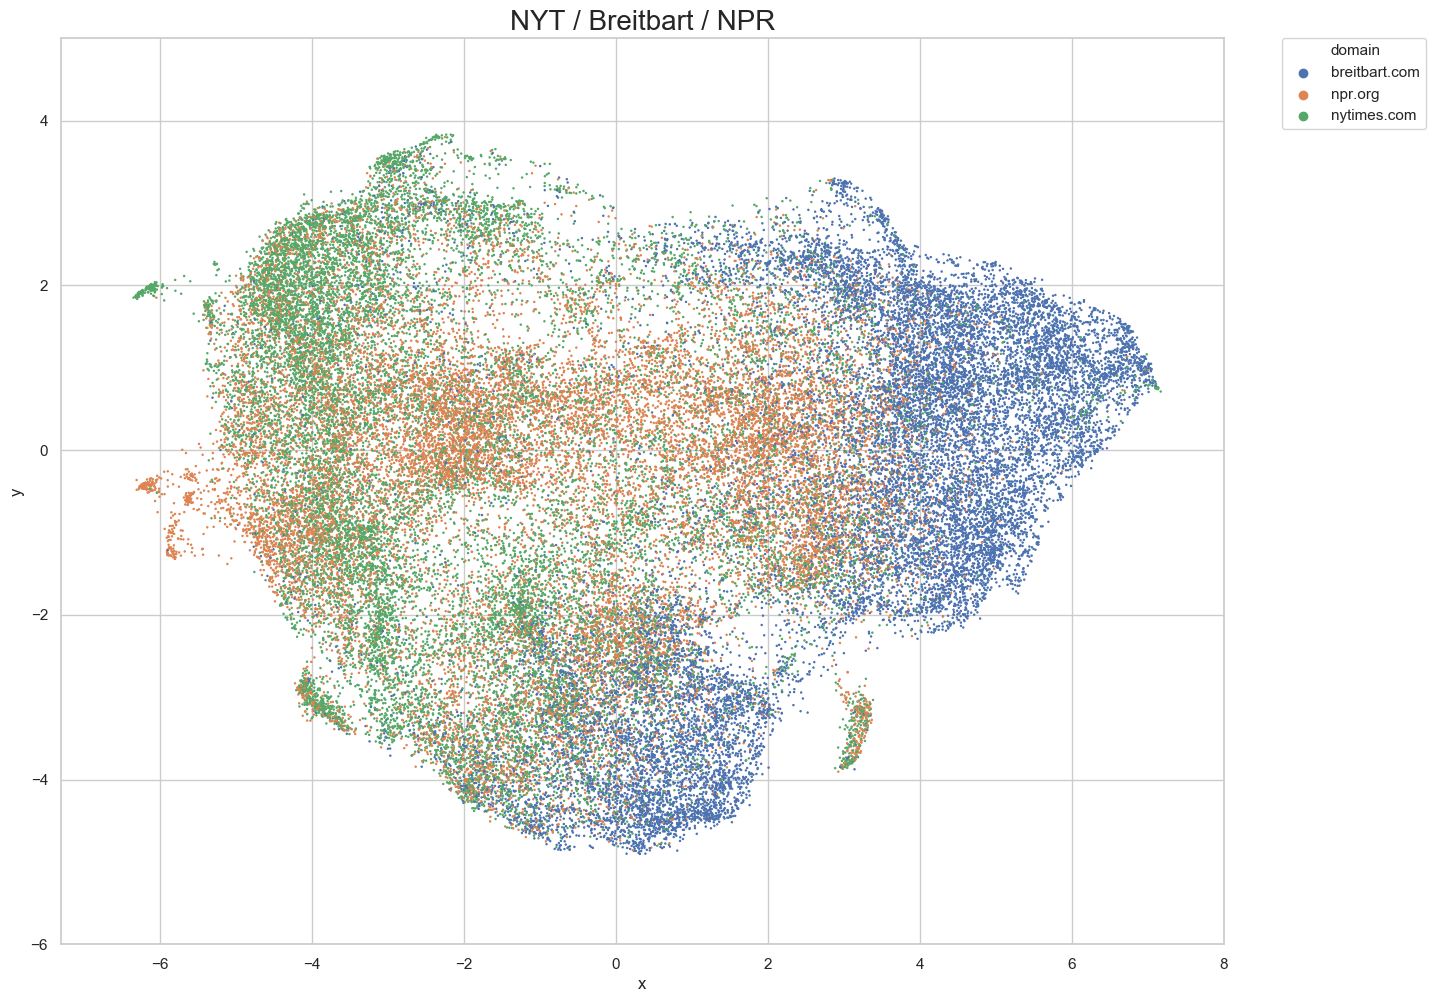

In [33]:
UMAP_POINTS = pdf.copy()
UMAP_POINTS['x'] = UMAP_EMBEDDING[:,0]
UMAP_POINTS['y'] = UMAP_EMBEDDING[:,1]

plt.figure(figsize=(15,12), dpi=100)
plt.xlim(-7.3,8)
plt.ylim(-6,5)

sns.scatterplot(
    x='x',
    y='y',
    data=UMAP_POINTS,
    s=1,
    edgecolor=None,
    alpha=1,
    hue='domain',
#     palette='tab20'
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('UMAP, 15 outlets, LSTM + attention', fontsize=20)
plt.title('NYT / Breitbart / NPR', fontsize=20)
plt.savefig('nyt-bb-npr.png', bbox_inches='tight')

In [29]:
for r in UMAP_POINTS[UMAP_POINTS.domain=='nytimes.com'].sort_values('p_breitbart.com', ascending=False).head(10).to_dict('records'):
    print(r['title'], r['p_breitbart.com'])

Challenging Hamas , Palestinian Authority Cuts Electricity Payments for Gaza 0.850505530834198
Amnesty Report Accuses Syria of Executing Thousands Since War Began 0.8024141192436218
ISRAEL REJECTS REAGAN PLAN FOR PALESTINIANS ' SELF RULE ; TERMS IT ' A SERIOUS DANGER ' ; The Israeli communique , page A8 . 0.7915012836456299
Global News Quiz : Russia Sanctions , North Korea Milestone , Pakistan Change , Iran Partner 0.7729375958442688
Hijab wearing teen prevented from competing in regional basketball game 0.762617290019989
Afghan Deported Amid German Migrants Row Kills Himself on Return Home 0.7499710321426392
Jihadists Receiving Most Arms Sent to Syrian Rebels 0.7487286329269409
Iranian Chess Player , Shunned for Refusing to Wear Hijab , to Play in U.S. 0.7373270392417908
Hungary Election Gives Orban Big Majority , and Control of Constitution 0.7317324876785278
Breitbart News Hires Veteran Wall Street Journal Reporter to Run New Finance Section 0.6718159317970276
